<a href="https://colab.research.google.com/github/mathur-exe/Transfer-Learning/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
from torchvision.datasets.utils import download_url
import tarfile 
from torchvision.datasets import ImageFolder 
from torch.utils.data import Dataset
import os
from PIL import Image
import torchvision.transforms as T
from torchvision import models 
import torch
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.tensorboard import SummaryWriter

In [42]:
# !pip install opendatasets --upgrade --quiet

# import opendatasets as od

# dataset_url = 'https://www.kaggle.com/thedagger/pokemon-generation-one'
# od.download(dataset_url)

## Data Download

In [43]:
download_url('https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz', '.')

Using downloaded and verified file: ./oxford-iiit-pet.tgz


In [44]:
with tarfile.open('/content/oxford-iiit-pet.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [45]:
data_dir = '/content/data/oxford-iiit-pet/images/'
files = os.listdir(data_dir)
files[:5]
# files = ImageFolder(data_dir)

['saint_bernard_170.jpg',
 'Egyptian_Mau_109.jpg',
 'english_cocker_spaniel_111.jpg',
 'beagle_1.jpg',
 'British_Shorthair_44.jpg']

## Lable Modifications

In [46]:
# '''
#   Since the image_names are in formate 'great_pyrenees_35.jpg'
#   We need to separate them at '_' and only keeping the initial name
# '''

def parse_breed(fname):
  parts = fname.split('_')
  return ' '.join(parts[:-1])



In [47]:
parse_breed(files[4])

'British Shorthair'

In [48]:
'''
'''

def open_image(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

## Custom PyTorch Dataset

In [49]:
class PetDataset(Dataset):
  def __init__(self, root, transform):
    super().__init__()
    self.root = root
    self.files = [fname for fname in os.listdir(root) if fname.endswith('.jpg')]
    # self.classes = list(set(files))
    self.classes = list(set(parse_breed(fname) for fname in files))
    self.transform = transform

  def __len__(self):
    return len(self.files)

  def __getitem__(self, i):
    fname = self.files[i]
    fpath = os.path.join(self.root, fname)
    img = self.transform(open_image(fpath))
    # class_idx = self.classes.index(files)
    class_idx = self.classes.index(parse_breed(fname))
    return img, class_idx

In [50]:
def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

In [51]:
img_size =224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
dataset = PetDataset(data_dir, T.Compose([
                                          T.Resize(img_size), 
                                          T.Pad(24, padding_mode='reflect'),
                                          T.RandomCrop(img_size), 
                                          T.ToTensor(), 
                                          T.Normalize(*imagenet_stats)]))

Label: english cocker spaniel (20)


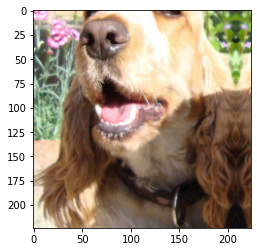

In [52]:
# show_image(*dataset[2])
show_image(*dataset[6])
# print(len(dataset))

## Training & Validation Dataset

In [53]:
from torch.utils.data import random_split 
val_size = int(0.1*len(dataset))
train_ds, valid_ds = random_split(dataset, [len(dataset)-val_size, val_size])

In [54]:
from torch.utils.data import DataLoader
batch_size = 256

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [55]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images[:64], *imagenet_stats)
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


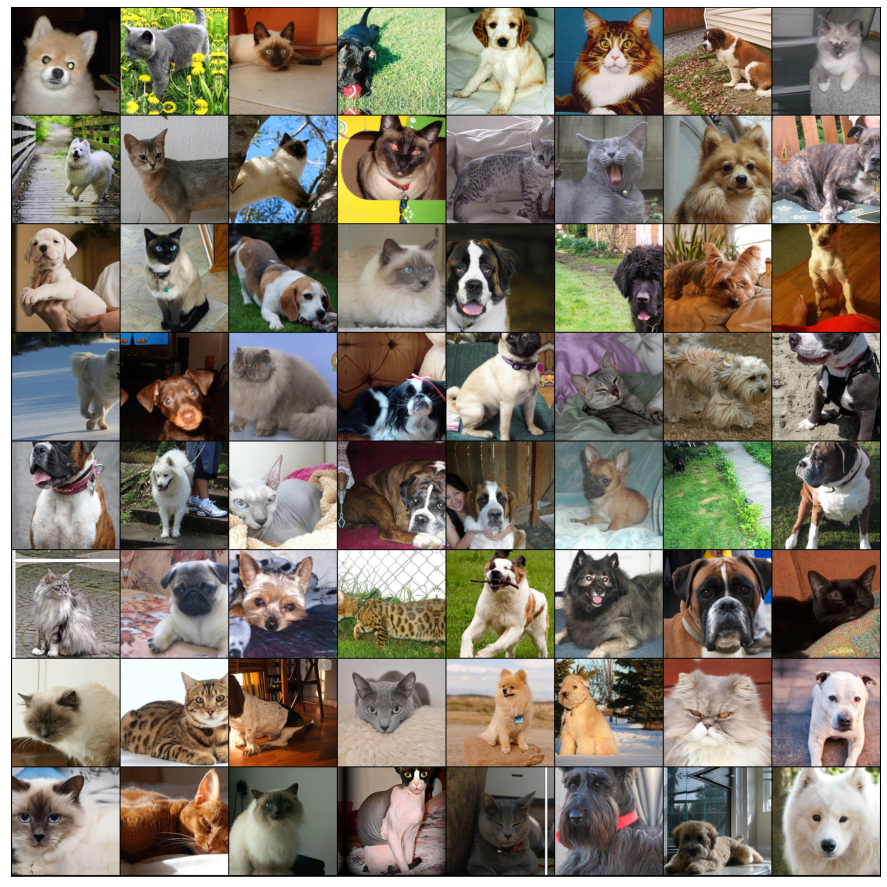

In [56]:
show_batch(train_dl)

## GPU Config

In [57]:
torch.cuda.is_available() # Checking if the GPU is available

True

In [58]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

## Modify Pretrained Model

In [59]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))

In [60]:
class PetModel(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

## Training Loop

In [61]:
import torch
from tqdm.notebook import tqdm
# writer = SummaryWriter(logdir)

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


# def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
#     history = []
#     optimizer = opt_func(model.parameters(), lr)
#     for epoch in range(epochs):
#         # Training Phase
#         model.train()
#         train_losses = []
#         for batch in tqdm(train_loader):
#             loss = model.training_step(batch)
#             train_losses.append(loss)
#             loss.backward()
#             optimizer.step()
#             optimizer.zero_grad()
#         # Validation phase
#         result = evaluate(model, val_loader)
#         result['train_loss'] = torch.stack(train_losses).mean().item()
#         model.epoch_end(epoch, result)
#         history.append(result)
#     return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            # writer.add_scalar('Loss/train', training_loss, global_step)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()       #resets the gradients to zero after each epoch

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    # writer.close()
    return history

## Finetuning Pretrained Model (ResNet34)

In [62]:
device_name = torch.cuda.get_device_name()
device = torch.device('cuda')
device

device(type='cuda')

In [63]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [64]:
model = PetModel(len(dataset.classes))
to_device(model, device);

In [65]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.02493460848927498, 'val_loss': 3.8605847358703613}]

In [84]:
epochs = 15
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [85]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/26 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0],last_lr: 0.00146, train_loss: 0.3077, val_loss: 0.9696, val_acc: 0.7392


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00430, train_loss: 0.4644, val_loss: 2.9513, val_acc: 0.4121


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.00756, train_loss: 1.0232, val_loss: 2.8743, val_acc: 0.3109


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00971, train_loss: 1.1605, val_loss: 2.9348, val_acc: 0.2447


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00994, train_loss: 1.0241, val_loss: 2.2325, val_acc: 0.4747


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.00950, train_loss: 0.8659, val_loss: 5.9853, val_acc: 0.2269


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [6],last_lr: 0.00867, train_loss: 0.8115, val_loss: 2.3756, val_acc: 0.4324


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [7],last_lr: 0.00750, train_loss: 0.7081, val_loss: 1.8997, val_acc: 0.5566


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [8],last_lr: 0.00611, train_loss: 0.5466, val_loss: 1.2689, val_acc: 0.6395


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [9],last_lr: 0.00463, train_loss: 0.4022, val_loss: 1.1273, val_acc: 0.6979


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [10],last_lr: 0.00317, train_loss: 0.2964, val_loss: 0.9860, val_acc: 0.7233


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [11],last_lr: 0.00188, train_loss: 0.1941, val_loss: 0.6891, val_acc: 0.8164


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [12],last_lr: 0.00087, train_loss: 0.1295, val_loss: 0.5955, val_acc: 0.8272


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [13],last_lr: 0.00022, train_loss: 0.1016, val_loss: 0.5721, val_acc: 0.8416


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [14],last_lr: 0.00000, train_loss: 0.0862, val_loss: 0.5714, val_acc: 0.8340
CPU times: user 4min 49s, sys: 4min, total: 8min 50s
Wall time: 20min 15s


In [86]:
torch.save(model.state_dict(), 'model.pth')

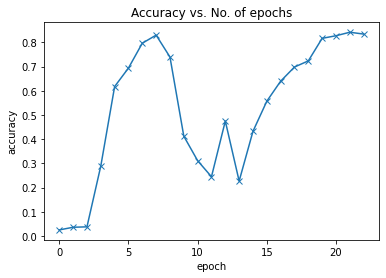

In [87]:
import matplotlib.pyplot as plt

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

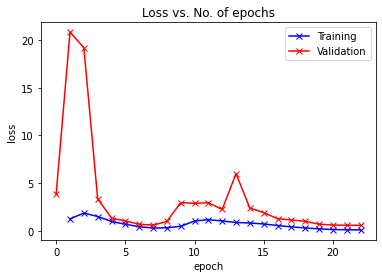

In [88]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [89]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

def show_image_prediction(img, label):
    plt.imshow(img.permute((1, 2, 0)))
    pred = predict_image(img, model, dataset.classes)
    print('Target:', dataset.classes[label])
    print('Prediction:', pred)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Target: Birman
Prediction: Birman


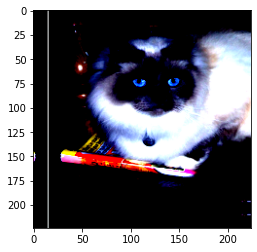

In [90]:
show_image_prediction(*valid_ds[100])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Target: beagle
Prediction: basset hound


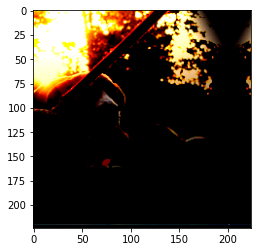

In [91]:
show_image_prediction(*valid_ds[123])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Target: Abyssinian
Prediction: Abyssinian


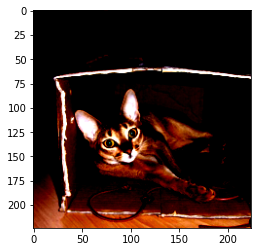

In [92]:
show_image_prediction(*valid_ds[199])